<div>
    <table style="border:2px solid white;" cellspacing="0" cellpadding="0" border-collapse: collapse; border-spacing: 0;>
      <tr> 
        <th style="background-color:white"> <img src="../media/ccal-logo-D3.png" width=225 height=225></th>
        <th style="background-color:white"> <img src="../media/logoMoores.jpg" width=175 height=175></th>
        <th style="background-color:white"> <img src="../media/GP.png" width=200 height=200></th>
        <th style="background-color:white"> <img src="../media/UCSD_School_of_Medicine_logo.png" width=175 height=175></th> 
        <th style="background-color:white"> <img src="../media/Broad.png" width=130 height=130></th> 
      </tr>
    </table>
</div>

<hr style="border: none; border-bottom: 3px solid #88BBEE;">
# **Onco-*GPS* Methodology**
## **Chapter 3. Decomposing Signature and Defining Transcriptional Components**

<div>
    <img src="../media/authors.png" width=900 height=50>
</div>

**Date:** April 17, 2017

**Article:** [*Kim et al.* Decomposing Oncogenic Transcriptional Signatures to Generate Maps of Divergent Cellular States](https://drive.google.com/file/d/0B0MQqMWLrsA4b2RUTTAzNjFmVkk/view?usp=sharing)

**Analysis overview:** In this chapter we will use the KRAS oncogenic signature genes that we generated in chapter 2 and we will decomposed them into non-negative matrix factorization components.

<div>
    <img src="../media/method_chap2.png" width=2144 height=1041>
</div>

To perfrom this analysis we will use as reference dataset 750 samples from the Broad-Novartis Cancer Cell Line Encyclopedia (CCLE) ([*Barretina et al. 2012*](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3320027/)). This dataset, hereafter denoted as $A^{n \times m}$, contains as rows the oncogenic signature genes and  samples representing many instances of the cellular states of interest. 

The decomposition is based on a Non-Negative Matrix Factorization (NMF) algorithm ([*Brunet et al. 2004*](https://www.ncbi.nlm.nih.gov/pubmed/15016911); [*Tamayo et al. 2007*](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1838404/)). These transcriptional components represent summaries of the most coherent gene expression patterns, relevant to the KRAS signature genes across the wide variety of cellular states and contexts represented in the reference dataset. The methodology contains the following analysis tasks:


*	*Normalization*. Normalize the input matrix $A^{n \times m}$ by replacing each gene expression entry by its column rank and obtain matrix $A^{n \times m}_{norm}$.


*	*Matrix Factorization.* Perform a standard non-negative matrix factorization (NMF) ([*Brunet et al. 2004*](https://www.ncbi.nlm.nih.gov/pubmed/15016911); [*Tamayo et al. 2007*](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1838404/), [*Cichocki et al. 2008*](http://www.bsp.brain.riken.jp/publications/2007/Cichocki-Zd-Amar_SPMAG.pdf))

<div>
    <img src="../media/chap3_equation.png" width=200 height=50>
</div>

*    The resulting matrices $W^{n \times k}$ and $H^{k \times m}$ have lower rank than the original matrix $A^{n \times m}_{norm}$ with $k << n, m$.


*	*Model selection.* Find an optimal number of components $k_{c}$ based on the numerical stability of multiple projections using different random seeds  ([*Brunet et al. 2004*](https://www.ncbi.nlm.nih.gov/pubmed/15016911)). The peaks of the cophenetic coefficient represent the more stable decompositions. 


The Matrix $H^{k \times m}$ has the same number of samples as $A^{n \times m}$ but a smaller number of rows and can be interpreted as a summarized version of the original dataset, i.e., one described in the space of the most salient transcriptional programs (components) rather than the original variables (genes). In the KRAS analysis performed below this procedure will produce 9 transcriptional components C1-C9. Restricting the decomposition process to operate using only the signature genes allowed us to emphasize the most relevant oncogene-driven transcriptional space and limit the effects of other transcriptional differences.

Go to the [next chapter (4)](4 Annotating the Transcriptional Components.ipynb).
Back to the [introduction chapter (0)](0 Introduction and Overview.ipynb).

<hr style="border: none; border-bottom: 3px solid #88BBEE;">
### 1. Set up notebook and import Computational Cancer Analysis Library ([CCAL](https://github.com/KwatME/ccal))

In [1]:
from environment2 import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

### 2. Read  signature and reference dataset 

Read the oncogenic signature generated in chapter 2

In [2]:
gene_scores = pd.read_csv(
    '../results/kras_signature.txt', sep='\t', index_col=0)

Read the reference dataset (the mRNA expression for the Cancer Cell Line Encyclopedia CCLE Datatset)

In [3]:
reference_dataset = read_gct('../data/ccle_gene_expression.gct')

### 3. Select the subset of rows corresponding to the KRAS signature genes

In [4]:
kras_relevant_genes = get_top_and_bottom_indices(gene_scores, 'score', 500).tolist()

In [5]:
reference_dataset_signature_genes = reference_dataset.loc[
    kras_relevant_genes, :]

### 4. Generate multiple NMF decompositions of the signature genes in the reference dataset

For this reference dataset we will explore NMF decompositions with a range of components from 2 to 12

Dropping axis-0 slices with at most 1 unique objects ...
Dropping axis-1 slices with at most 1 unique objects ...


/home/k/Jumis/tools/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


NMF with k=2 ...
	(k=2) 0/2 ...
	(k=2) 1/2 ...
Counting coclusterings ...
Computing clustering distances (1 - coclusterings) ...
Hierarchical cluster clustering distances and computing ccc ...


../tools/oncogps/oncogps/clustering/clustering/consensus_cluster.py:76: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  hc = linkage(distances, method=method)


NMF with k=3 ...
	(k=3) 0/2 ...
	(k=3) 1/2 ...
Counting coclusterings ...
Computing clustering distances (1 - coclusterings) ...
Hierarchical cluster clustering distances and computing ccc ...
NMF with k=4 ...
	(k=4) 0/2 ...
	(k=4) 1/2 ...
Counting coclusterings ...
Computing clustering distances (1 - coclusterings) ...
Hierarchical cluster clustering distances and computing ccc ...
NMF with k=5 ...
	(k=5) 0/2 ...
	(k=5) 1/2 ...
Counting coclusterings ...
Computing clustering distances (1 - coclusterings) ...
Hierarchical cluster clustering distances and computing ccc ...
NMF with k=6 ...
	(k=6) 0/2 ...
	(k=6) 1/2 ...
Counting coclusterings ...
Computing clustering distances (1 - coclusterings) ...
Hierarchical cluster clustering distances and computing ccc ...
NMF with k=7 ...
	(k=7) 0/2 ...
	(k=7) 1/2 ...
Counting coclusterings ...
Computing clustering distances (1 - coclusterings) ...
Hierarchical cluster clustering distances and computing ccc ...
NMF with k=8 ...
	(k=8) 0/2 ...
	(k

/home/k/Jumis/tools/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


ValueError: too many values to unpack (expected 3)

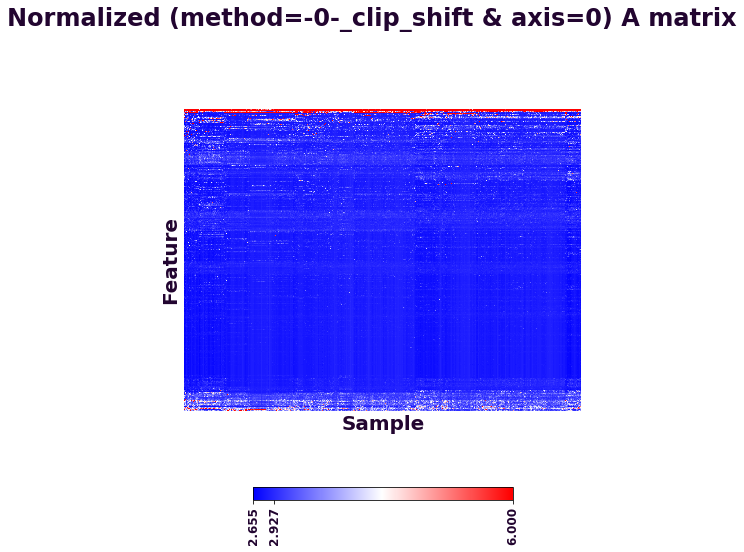

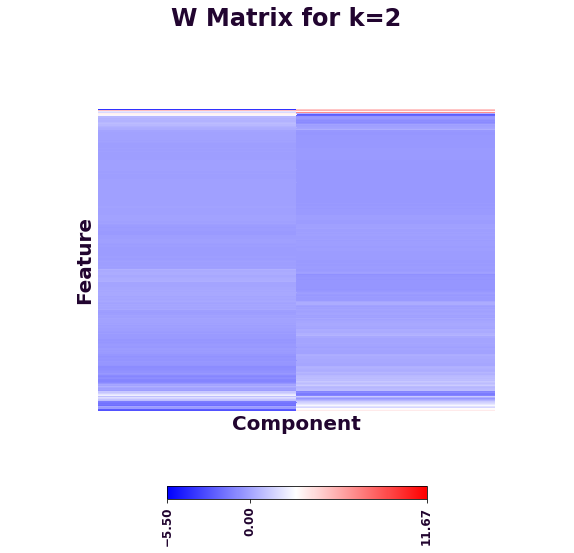

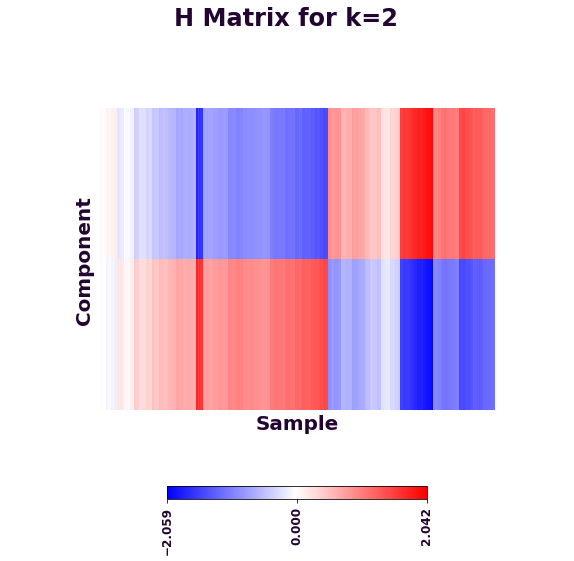

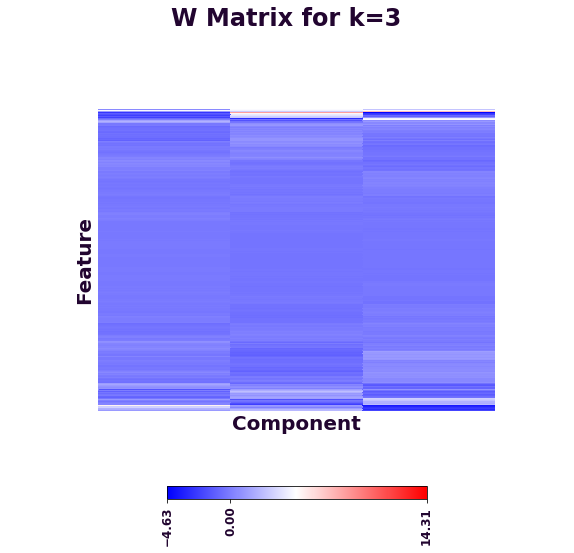

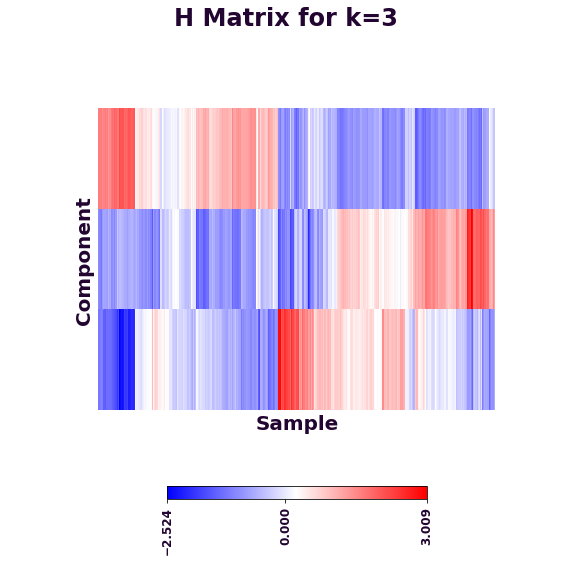

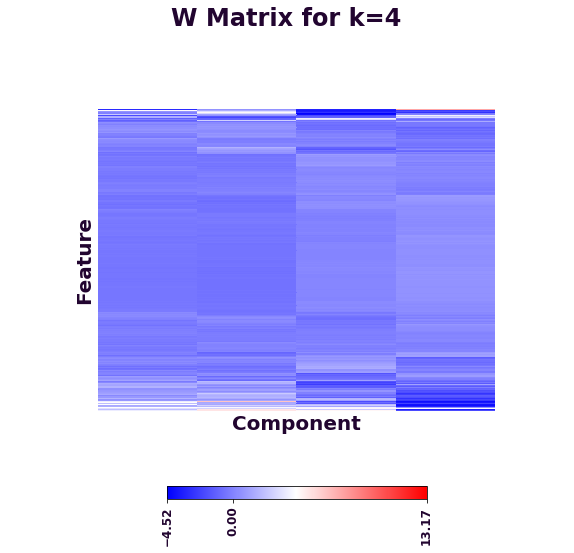

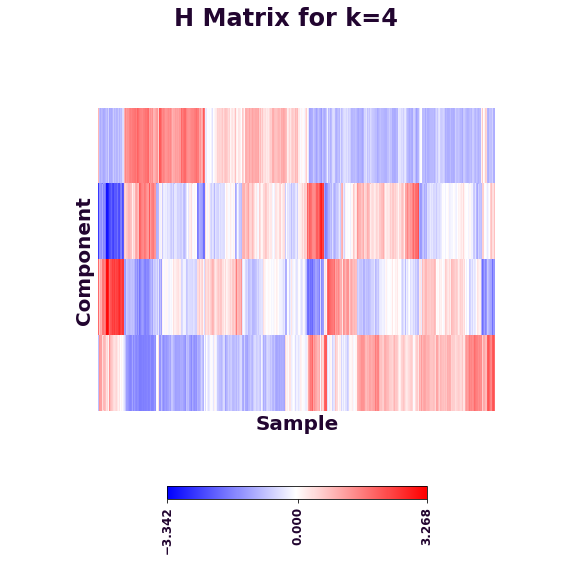

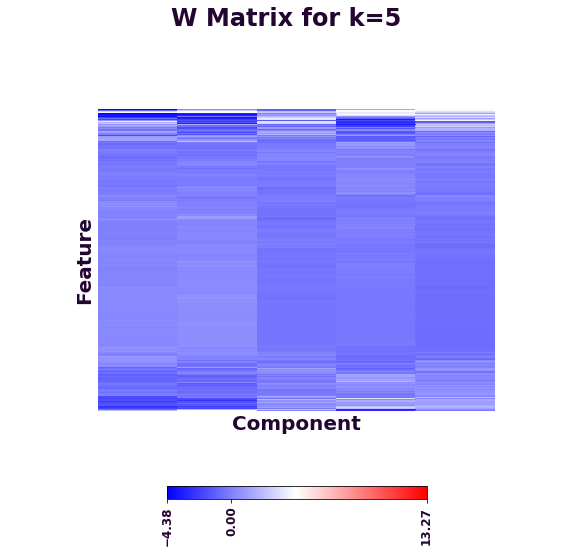

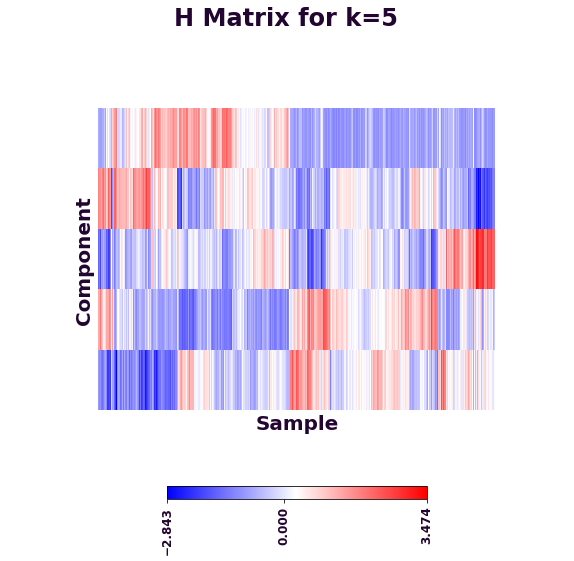

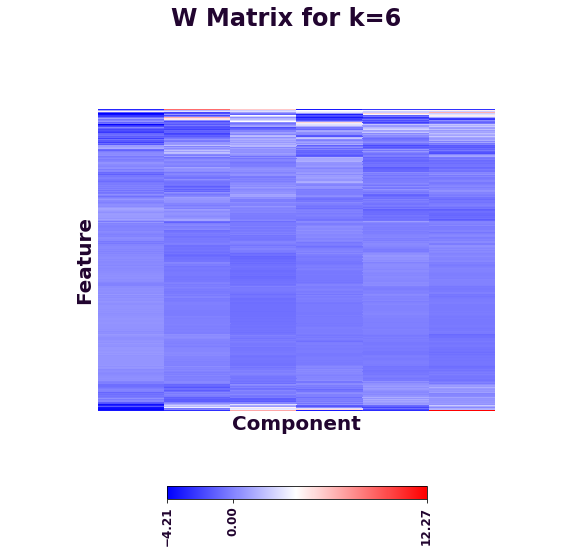

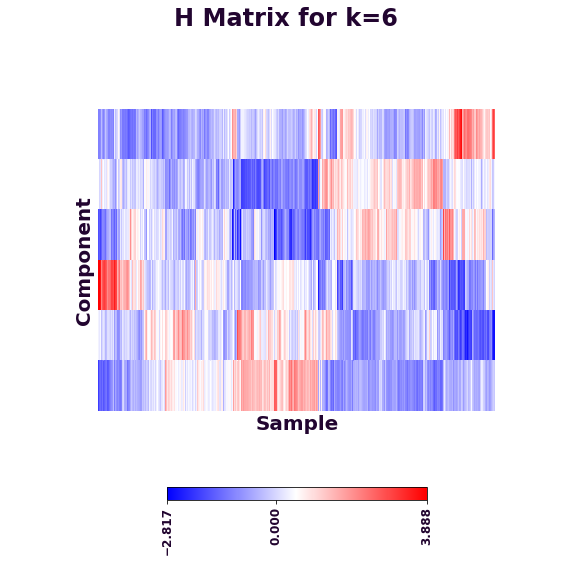

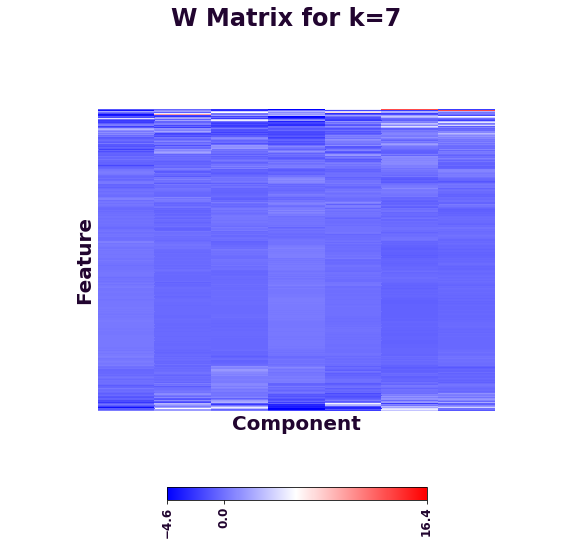

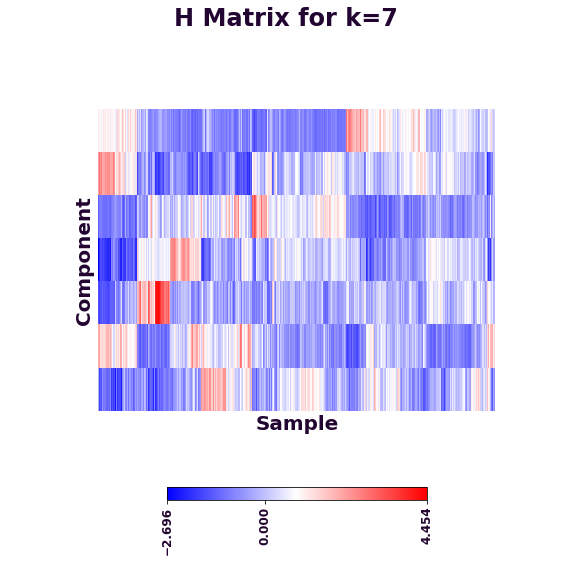

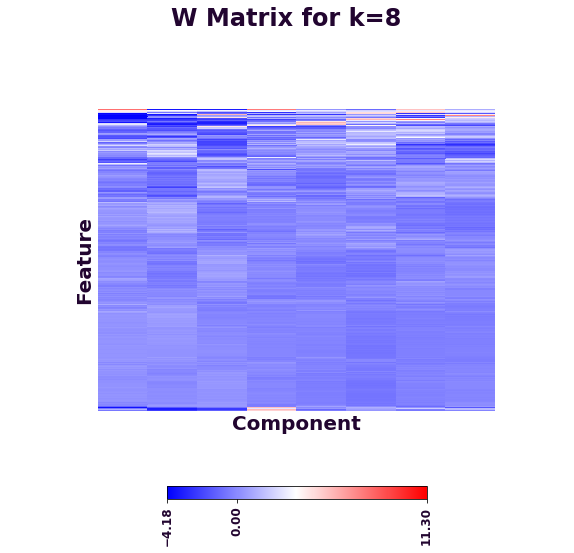

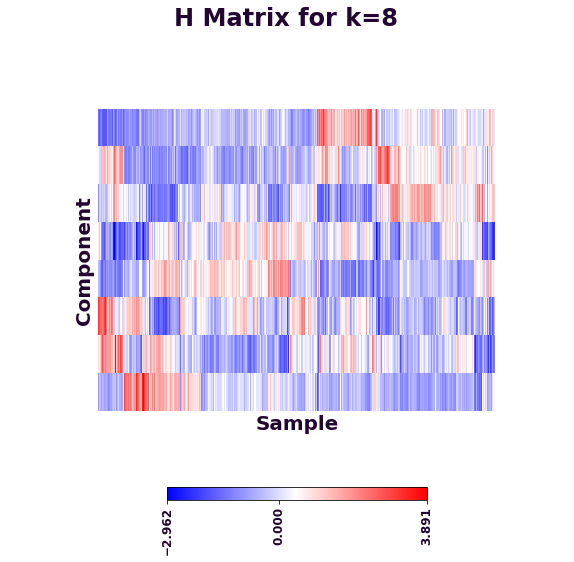

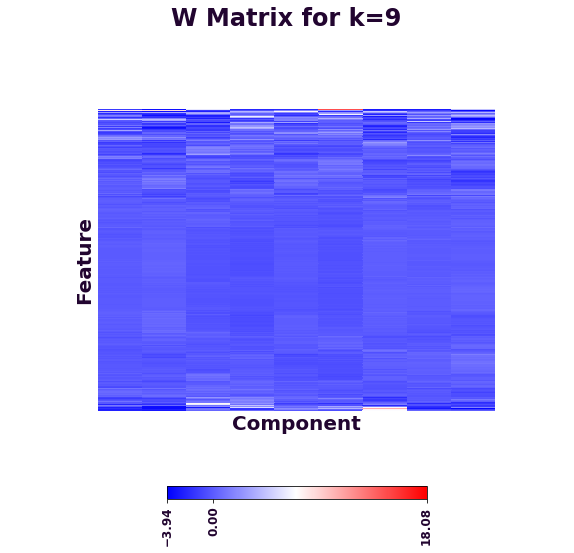

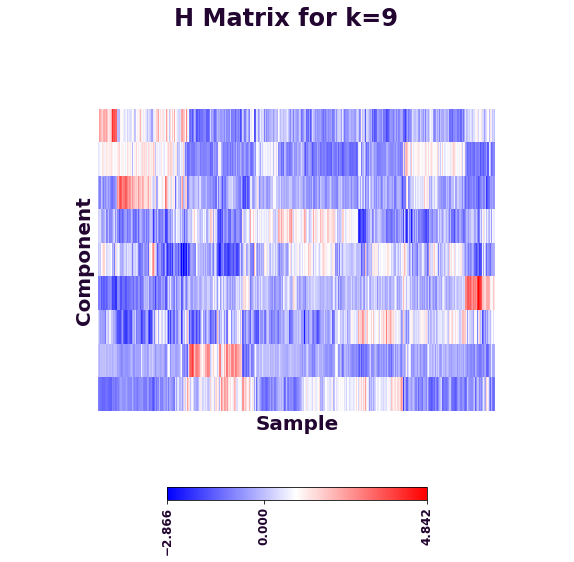

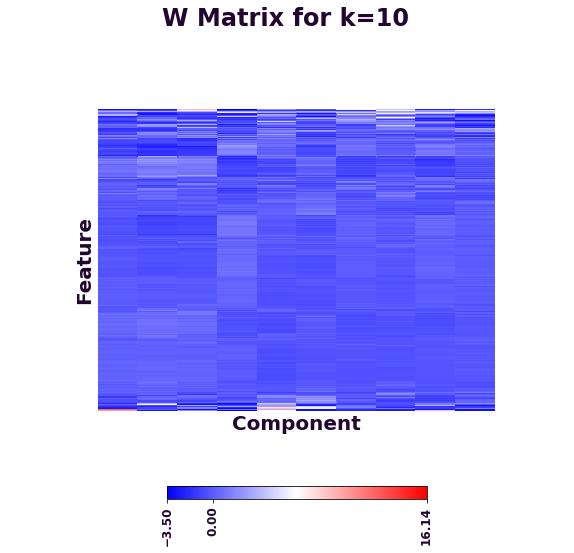

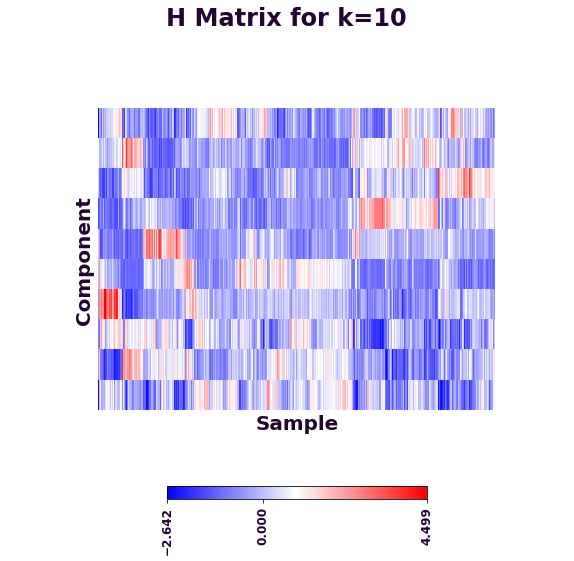

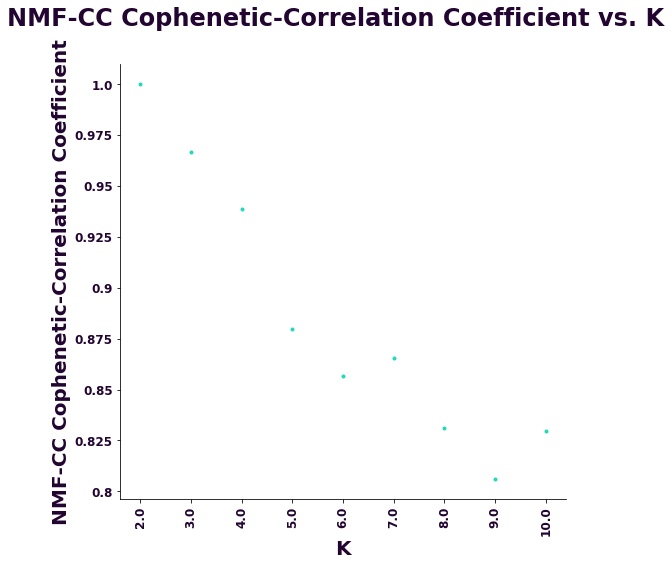

In [7]:
nmf_results, nmf_cc, cophenetic_correlation_coefficients = define_components(
    reference_dataset_signature_genes,
    range(2, 11),
    '../results2/',
    algorithm='LS',
    n_clusterings=2,
    random_seed=6137)

### 5. Choose optimal decomposition (k=9) and define NMF components

Looking at the results of the prior computation we can see that there is an optimal solution for k= 9 components. The code below reads the $W$ and $H$ matrices corresponding to 9 components.

Here  we will also relabeled the component to match the labeling used in the article. The reason for the different labeling is because the original component numbers used in the article were generated using an earlier version of the Onco-*GPS* code written in the R language that used different random numbers to initiallize the $W$ and $H$ matrices.

In [ ]:
w_matrix = read_gct('../results/nmf_cc/nmf/nmf_k9_w.gct')
w_matrix

In [ ]:
h_matrix = read_gct('../results/nmf_cc/nmf/nmf_k9_h.gct')
h_matrix

In [ ]:
indices = ['C1', 'C3', 'C9', 'C8', 'C6', 'C7', 'C5', 'C2',
           'C4']  # Relabel components to have same names as in the paper

In [ ]:
h_matrix.index = indices

In [ ]:
w_matrix.columns = indices

In [ ]:
write_gct(h_matrix, '../results/nmf_cc/nmf/nmf_k9_h.gct')

In [ ]:
write_gct(w_matrix, '../results/nmf_cc/nmf/nmf_k9_w.gct')

Plot the W and H matrices for k=9 components (this H matrix is shown on the right of Fig 3 in the article)

In [ ]:
plot_nmf(w_matrix, h_matrix, figure_size=(16, 16))

### 6. Compare the NMF components with each other using the information coefficient
This computation generates an association matrix that compares the component profiles against each other using the Information Coefficient. This is figure S6A in the article and shows that the components are distinct.

In [ ]:
CM = make_comparison_panel(
    np.array(h_matrix),
    np.array(h_matrix),
    axis=1,
    figure_size=(16, 16),
    a2d0_name='Component',
    a2d1_name='Component')